<a href="https://colab.research.google.com/github/AkashRamkaran/Automobile/blob/main/A_Ramkaran_Project3_assn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1️⃣ Data Loading
We begin by loading the automobile dataset directly from GitHub and assigning column names based on UCI documentation.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


# Load data
data_path = "https://raw.githubusercontent.com/AkashRamkaran/Automobile/main/automobile/imports-85.data.txt"
columns = [
    "symboling", "normalized-losses", "make", "fuel-type", "aspiration",
    "num-of-doors", "body-style", "drive-wheels", "engine-location",
    "wheel-base", "length", "width", "height", "curb-weight",
    "engine-type", "num-of-cylinders", "engine-size", "fuel-system",
    "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm",
    "city-mpg", "highway-mpg", "price"
]
df = pd.read_csv(data_path, names=columns, na_values="?")
numeric_columns = [
    "normalized-losses", "wheel-base", "length", "width", "height", "curb-weight",
    "engine-size", "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm",
    "city-mpg", "highway-mpg", "price"
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


This is the data loading part, we're seeing the first 5 rows to see the accuracy.

## 2️⃣ Exploratory Data Analysis
We now explore the dataset by visualizing the distributions and checking for outliers and missing data.

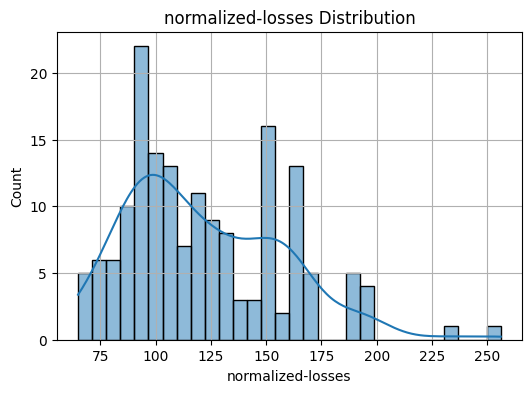

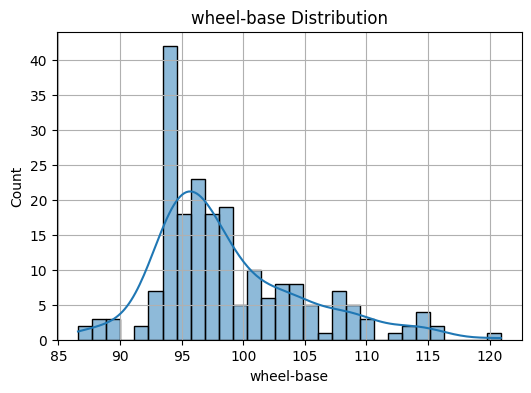

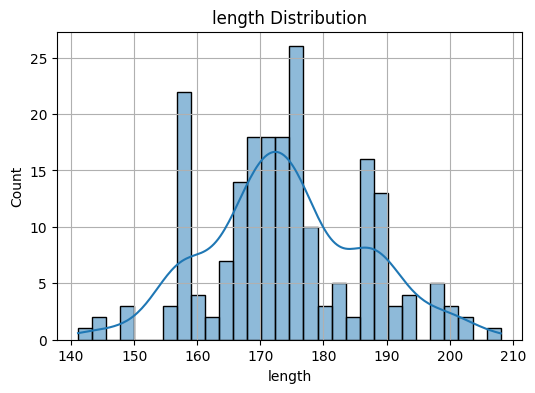

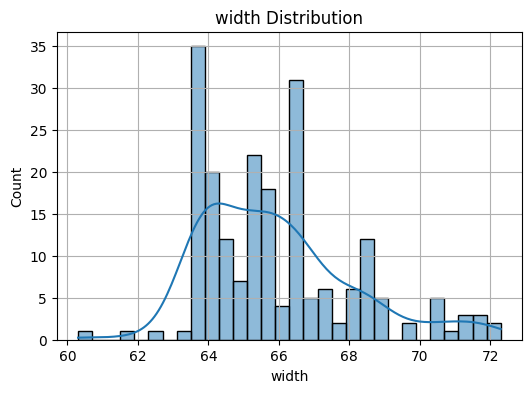

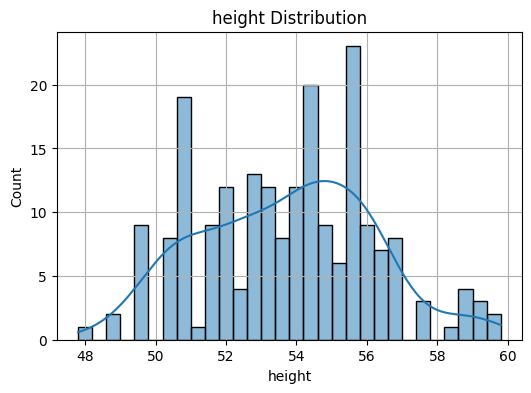

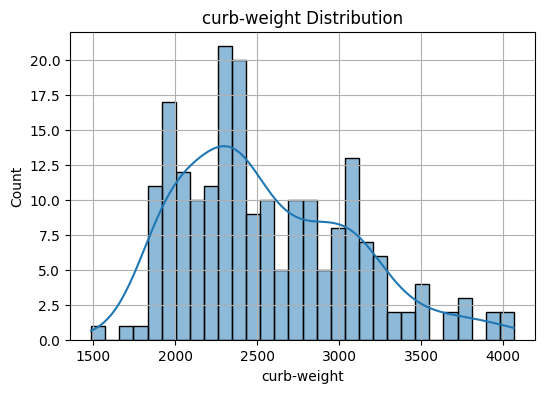

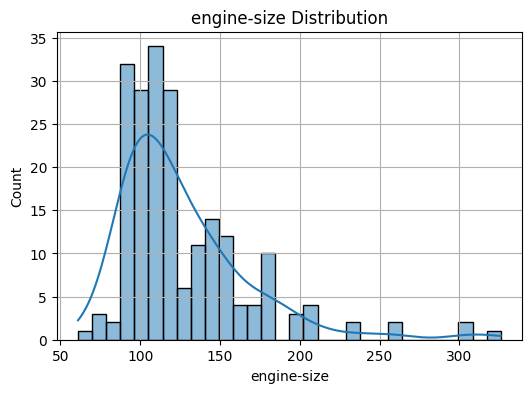

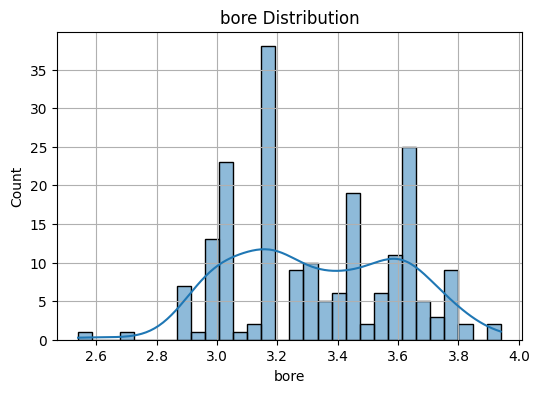

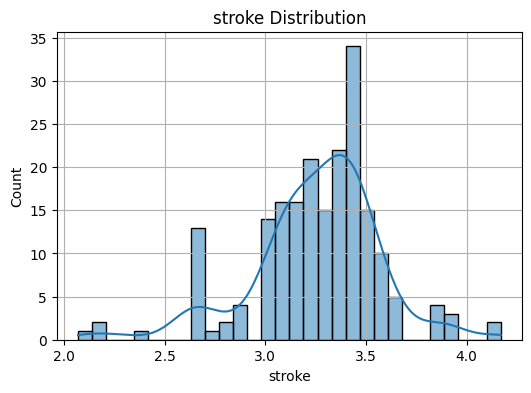

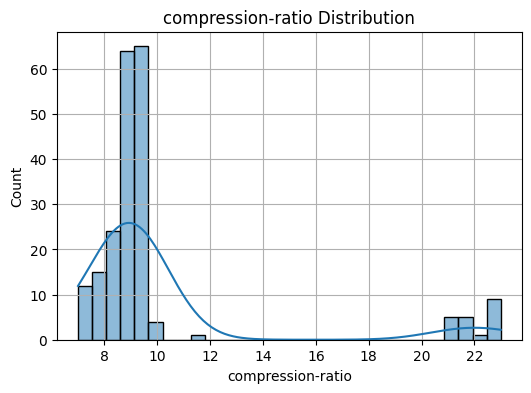

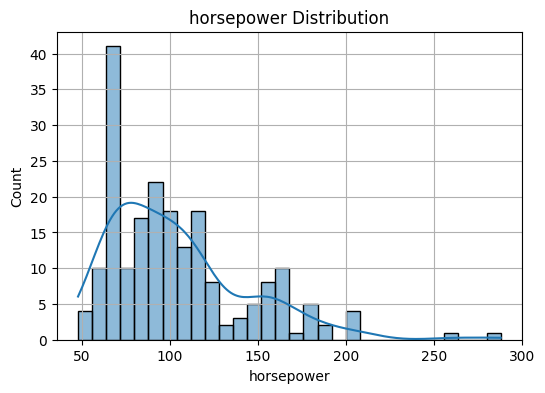

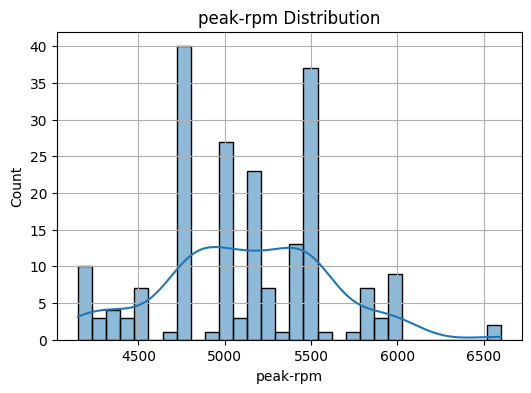

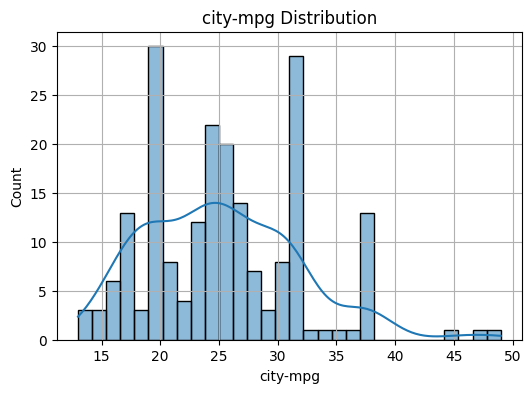

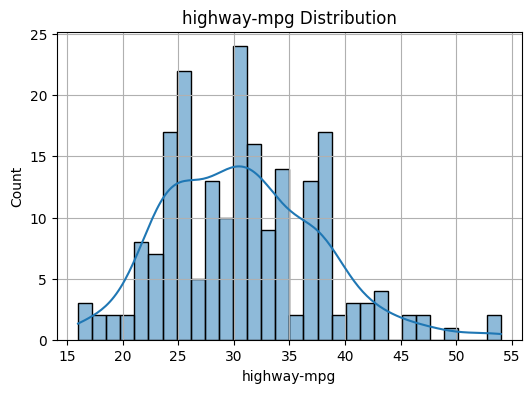

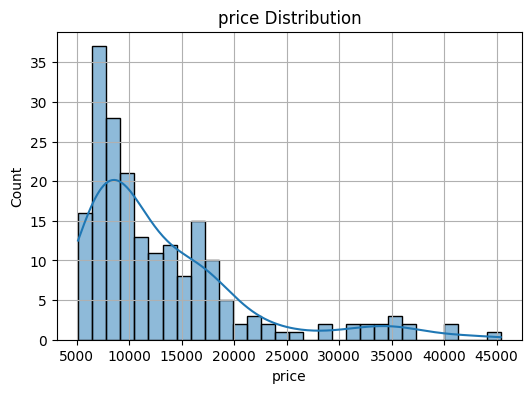

In [18]:
# Visualize distributions
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"{col} Distribution")
    plt.grid(True)
    plt.show()

- stroke Distribution
Roughly bell-shaped (close to a normal distribution)

Most values are centered around 2.9 to 3.5

Few extreme values → not heavily skewed

- compression-ratio Distribution
Right-skewed (positive skew)

Most values fall between 8 and 10

A sharp increase around 22 indicates outliers or rare cases

- horsepower Distribution
Also right-skewed

Majority of values are between 60 and 120

Outliers exist above 200 HP, indicating some high-performance vehicles

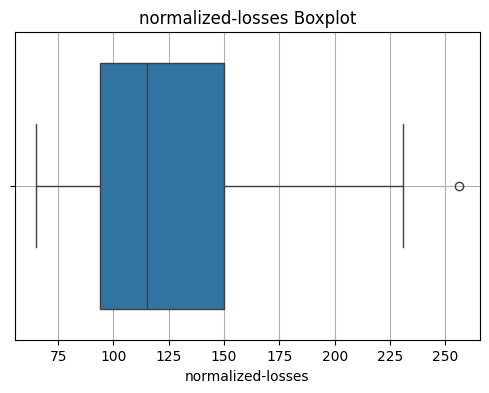

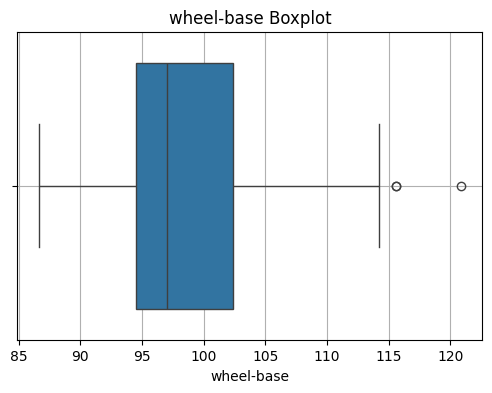

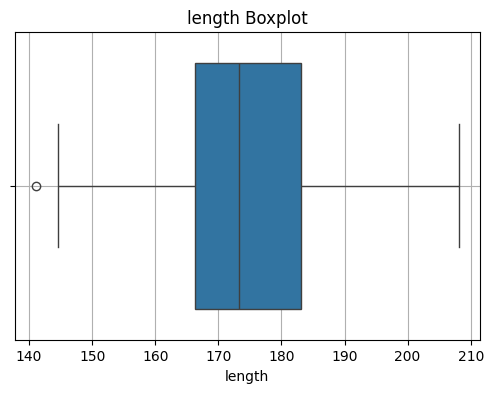

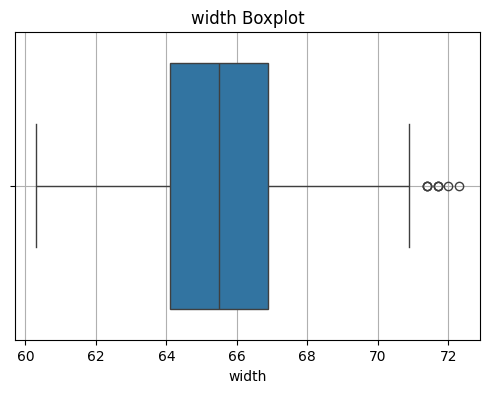

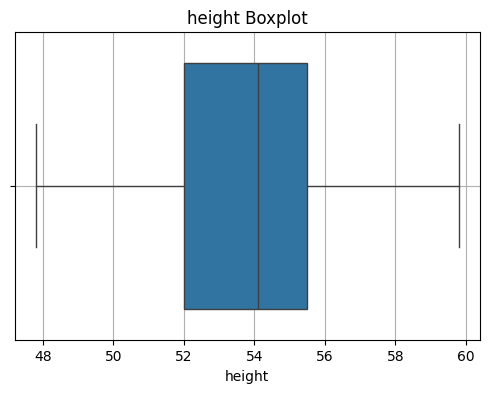

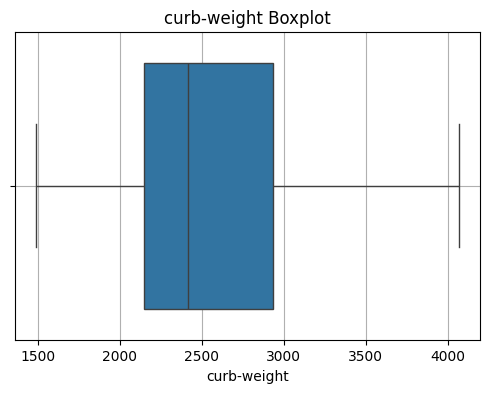

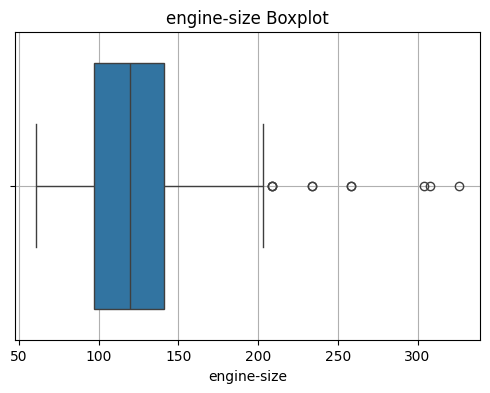

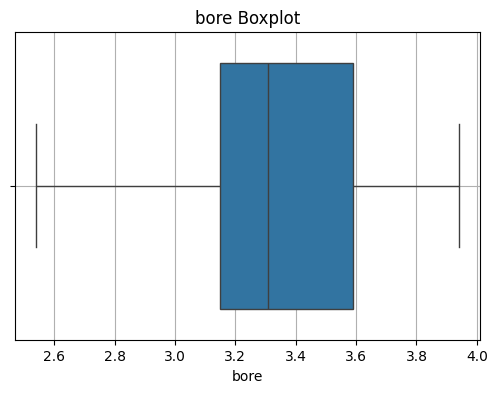

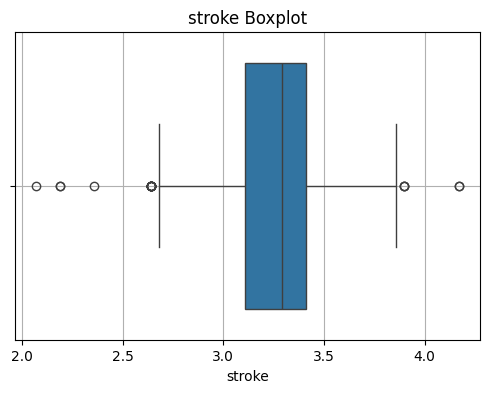

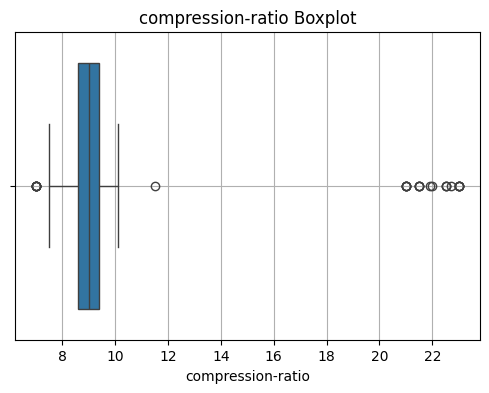

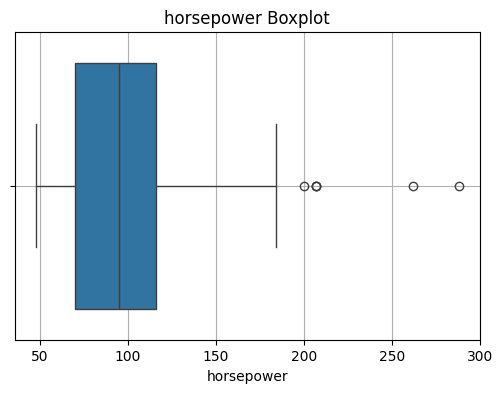

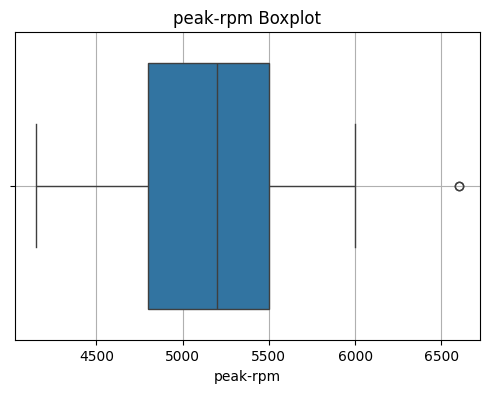

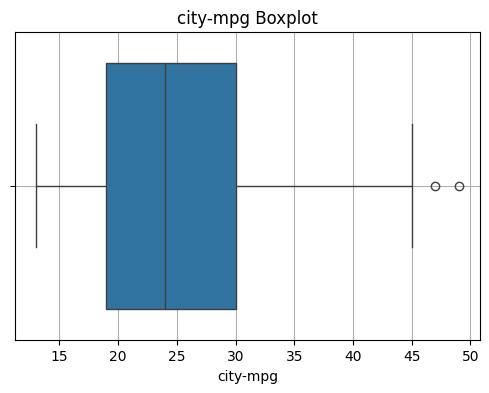

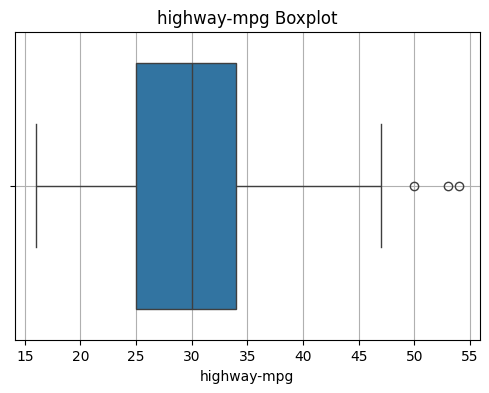

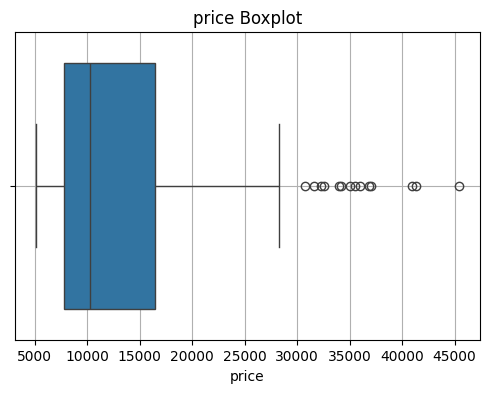

In [19]:
# Visualize outliers with boxplots
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col].dropna())
    plt.title(f"{col} Boxplot")
    plt.grid(True)
    plt.show()

-normalized-losses Boxplot
The box represents the interquartile range (IQR) from Q1 to Q3

A few data points on the right are outliers (greater than 1.5 × IQR)

The variable has a long right tail suggesting positive skew

-wheel-base Boxplot
Most values fall between ~95 and ~105

A couple of outlier values above 115–120

The data is mostly concentrated in the middle with low skew

-length Boxplot
Fairly symmetric distribution

Few minor outliers on both ends

Most values lie tightly between 170–190

In [20]:
# Check missing values
df[numeric_columns + ['num-of-doors']].isnull().sum()

,0
normalized-losses,41
wheel-base,0
length,0
width,0
height,0
curb-weight,0
engine-size,0
bore,4
stroke,4
compression-ratio,0


numeric_columns + ['num-of-doors']:
Combines all numeric columns plus the categorical column 'num-of-doors' into a subset of the dataframe.

.isnull():
Checks each value in the selected columns to see if it’s missing (NaN or null). Returns True for missing, False otherwise.

.sum():
Sums up the True values column-wise to give a count of missing values per column.



normalized-losses: 41 missing values

stroke: 4 missing values

bore: 4 missing values

horsepower, peak-rpm: 2 each

price: 4 missing values
num-of-doors: 2 missing values

## 3️⃣ Q1: Variables Needing Feature Scaling
We identify variables that require scaling due to large value ranges or skewed distributions.

In [21]:
# 🔹 Q1: Feature Scaling
# These variables vary in scale, and models like SVM, KNN, and gradient descent-based models are sensitive to such differences.
# If left unscaled, larger-magnitude features like 'curb-weight' and 'price' will dominate model training.
# Feature scaling brings all variables to a comparable range.


**Variables that need feature scaling:**
- `curb-weight`
- `engine-size`
- `horsepower`
- `price`
- `compression-ratio`
- `peak-rpm`
- `wheel-base`, `length`, `width`, `height`





## 4️⃣ Q2: Imputation of Missing Data
We address missing values in `num-of-doors` and `price` using group-based logic instead of mean/median/mode.

In [22]:
# Impute 'num-of-doors' using most common value per 'body-style'
door_map = {"two": 2, "three": 3, "four": 4, "five": 5}
door_impute_map = df.groupby("body-style")["num-of-doors"].agg(lambda x: x.mode().iloc[0])
df["num-of-doors"] = df.apply(
    lambda row: door_impute_map[row["body-style"]] if pd.isna(row["num-of-doors"]) else row["num-of-doors"], axis=1)
df["num-of-doors"] = df["num-of-doors"].replace(door_map).astype(int)

# Impute 'price' by group average
df["price"] = df.groupby(["make", "body-style"])["price"].transform(lambda x: x.fillna(x.mean()))
df["price"] = df.groupby("make")["price"].transform(lambda x: x.fillna(x.mean()))

In [23]:
# 🔹 Q2: Imputation Strategy
# We used group-based imputation instead of mean/median/mode to avoid introducing bias.
# For 'num-of-doors', we used the most common value by 'body-style'.
# For 'price', we used the average value by ('make', 'body-style') and fallback to 'make' if needed.
# This retains affected records and preserves data structure without central tendency bias.

## 5️⃣ Q3: Scaling `engine-size` and `stroke`
We apply MinMax scaling to `engine-size` and Standardization to `stroke`, and compare the distributions before and after.

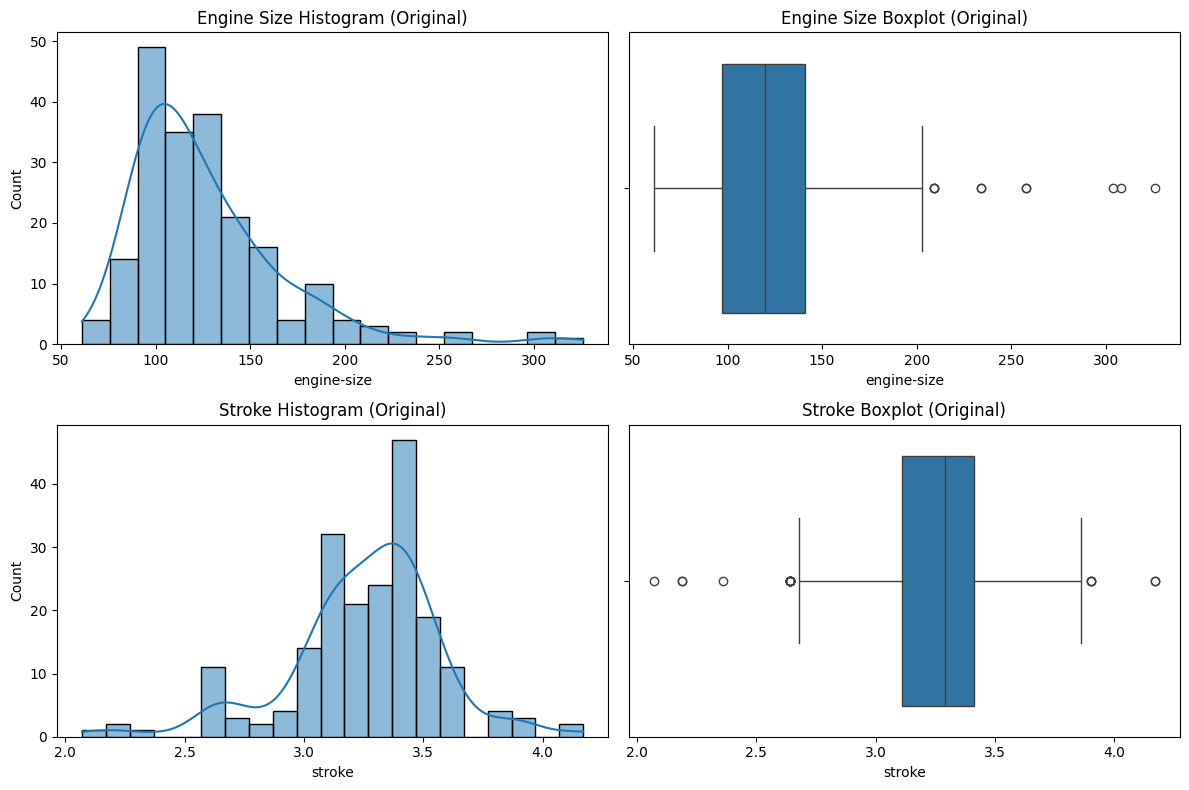

In [25]:
# Before scaling
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df["engine-size"].dropna(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Engine Size Histogram (Original)")
sns.boxplot(x=df["engine-size"].dropna(), ax=axes[0, 1])
axes[0, 1].set_title("Engine Size Boxplot (Original)")
sns.histplot(df["stroke"].dropna(), kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Stroke Histogram (Original)")
sns.boxplot(x=df["stroke"].dropna(), ax=axes[1, 1])
axes[1, 1].set_title("Stroke Boxplot (Original)")
plt.tight_layout()
plt.show()

-Engine Size Histogram (Original)
Right-skewed distribution (long tail to the right)

Most cars have smaller engines between 100 and 150

A few cars have very large engines (> 250), creating outliers

-Engine Size Boxplot (Original)
Clear outliers shown as dots on the right

Median engine size is slightly below center (due to skew)

-Stroke Histogram (Original)
A bit irregular, slightly bimodal

Peaks around ~3.0 and ~3.5

Less extreme skew compared to engine-size

-Stroke Boxplot (Original)
Some mild outliers on both ends

Distribution more balanced than engine-size

In [26]:
# 🔹 Q3: Scaling Method Explanation
# We used Min-Max scaling for 'engine-size' because it's suitable for values with known bounds (0–1).
# We used StandardScaler for 'stroke' to normalize values based on standard deviation and mean.
# The visualizations show how the distributions are compressed or centered after scaling.

In [27]:
# Apply scaling
df["engine-size-scaled"] = MinMaxScaler().fit_transform(df[["engine-size"]])
df["stroke-scaled"] = StandardScaler().fit_transform(df[["stroke"]])

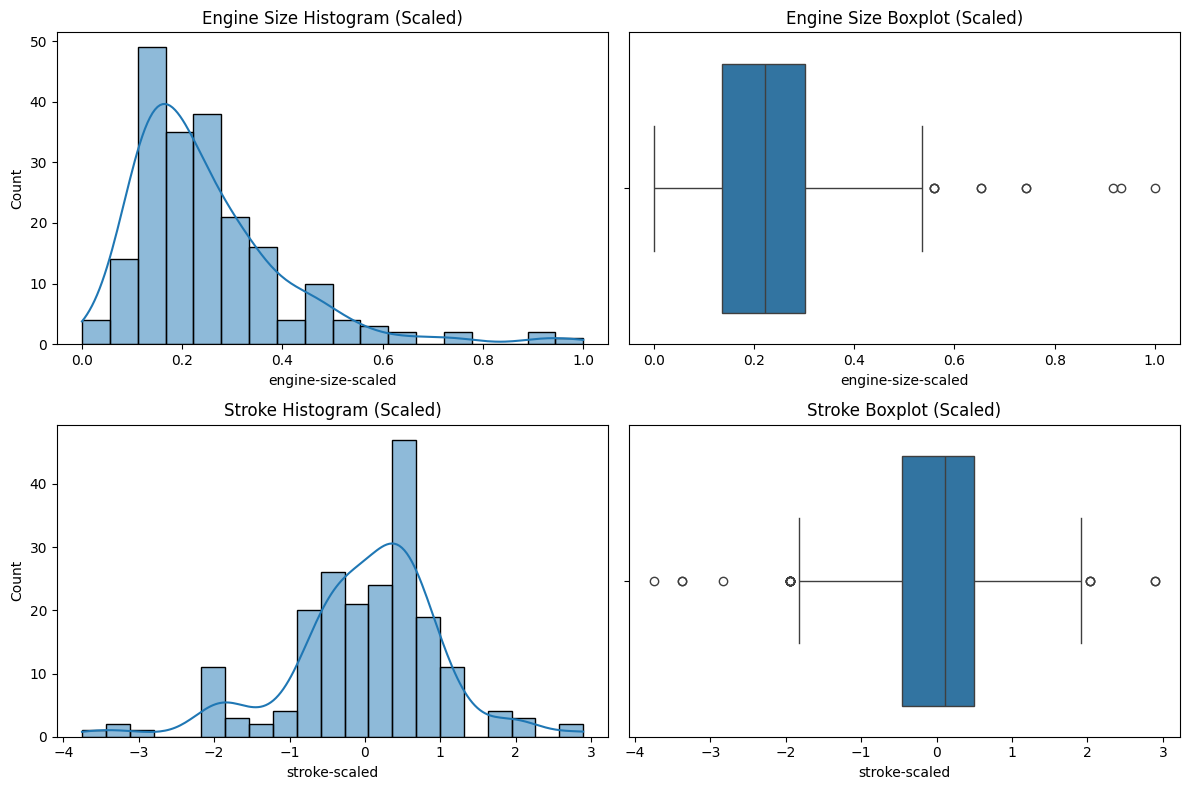

In [28]:
# After scaling
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df["engine-size-scaled"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Engine Size Histogram (Scaled)")
sns.boxplot(x=df["engine-size-scaled"], ax=axes[0, 1])
axes[0, 1].set_title("Engine Size Boxplot (Scaled)")
sns.histplot(df["stroke-scaled"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Stroke Histogram (Scaled)")
sns.boxplot(x=df["stroke-scaled"], ax=axes[1, 1])
axes[1, 1].set_title("Stroke Boxplot (Scaled)")
plt.tight_layout()
plt.show()

-engine-size-scaled
Now scaled between 0 and 1 due to Min-Max Scaling

Distribution shape (right-skew) is preserved, but the range is normalized

Outliers remain present, but their values are compressed

-stroke-scaled
Now centered around 0 with standard deviation ~1 using StandardScaler

Slight skew is still visible but scaled to fit a standard normal-like range

Outliers now fall beyond -2 or +2 (standard deviations)